In [17]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

from dynchro.tl import dtw, traceback, warp_pseudotime, dynchronize, get_kde_eval, get_wasserstein_distance, get_cutoff_kde
from dynchro.pl import plot_distance_matrix, plot_cost_matrix, plot_dtw_matrices, plot_kde_comparison

from utils import plot_iroot, comp_kde, kdeplot, kdeplot2, compare, norm

random.seed(34)
np.random.seed(34)

In [2]:
%load_ext autoreload
%autoreload 2

# 1. Read in data

In [3]:
d1 = ad.read_h5ad("data/dynchro1_slingshot_processed.h5ad")
d2 = ad.read_h5ad("data/dynchro2_slingshot_processed.h5ad")
d2.obs["milestones"] = d2.obs.milestones.cat.rename_categories({'sC': 'sC_batch'})

In [4]:
d1.X = d1.layers["X"]
d2.X = d2.layers["X"]

# 2. Sort lineages

In [5]:
def get_sorted_lineage(d, pseudotime_col, lineage_col):
    lineage = d[d.obs[lineage_col] == "TRUE"]
    sorting = np.argsort(lineage.obs[pseudotime_col])
    sorted_lin = lineage[sorting, :]
    return sorted_lin

In [6]:
d1_linC = get_sorted_lineage(d1, "orig_linC_pseudotime", "linC")
d1_linD = get_sorted_lineage(d1, "orig_linD_pseudotime", "linD")
d2_linC = get_sorted_lineage(d2, "orig_linC_pseudotime", "linC")
d2_linD = get_sorted_lineage(d2, "orig_linD_pseudotime", "linD")

In [7]:
d1_linC.obs["orig_pseudotime"] = d1_linC.obs["orig_linC_pseudotime"]
d2_linC.obs["orig_pseudotime"] = d2_linC.obs["orig_linC_pseudotime"]
d1_linD.obs["orig_pseudotime"] = d1_linD.obs["orig_linD_pseudotime"]
d2_linD.obs["orig_pseudotime"] = d2_linD.obs["orig_linD_pseudotime"]

/tmp/ipykernel_165198/3163897231.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d1_linC.obs["orig_pseudotime"] = d1_linC.obs["orig_linC_pseudotime"]
/tmp/ipykernel_165198/3163897231.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d2_linC.obs["orig_pseudotime"] = d2_linC.obs["orig_linC_pseudotime"]
/tmp/ipykernel_165198/3163897231.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d1_linD.obs["orig_pseudotime"] = d1_linD.obs["orig_linD_pseudotime"]
/tmp/ipykernel_165198/3163897231.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  d2_linD.obs["orig_pseudotime"] = d2_linD.obs["orig_linD_pseudotime"]


# 3. Dynchronize

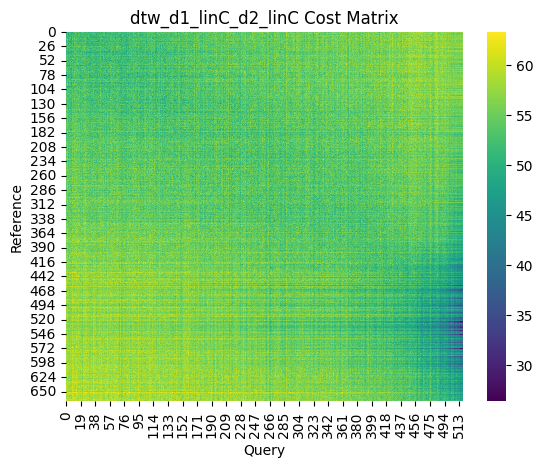

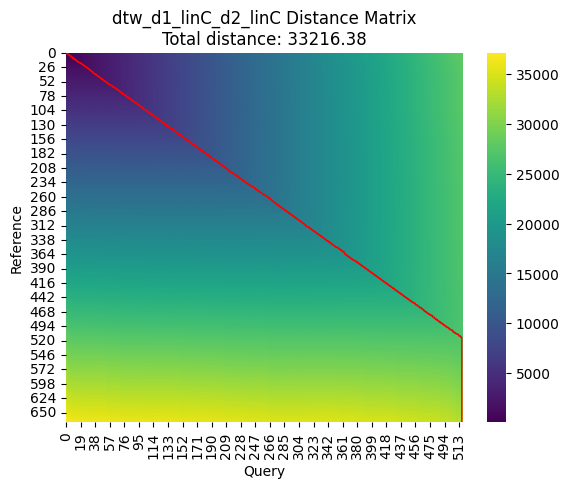

In [8]:
dynchronize(d1_linC, d2_linC, dtw_key="dtw_d1_linC_d2_linC", pseudotime_key="orig_pseudotime")

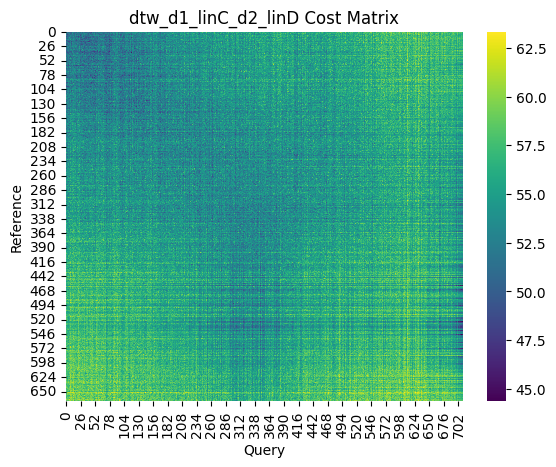

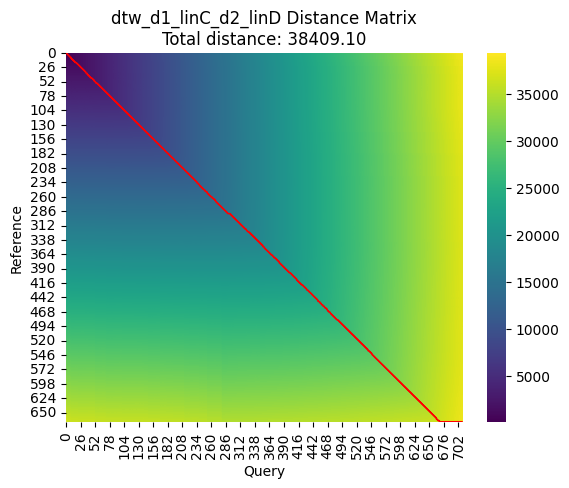

In [9]:
dynchronize(d1_linC, d2_linD, dtw_key="dtw_d1_linC_d2_linD", pseudotime_key="orig_pseudotime")

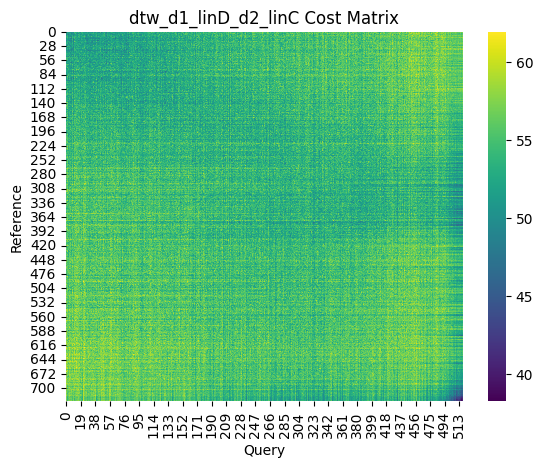

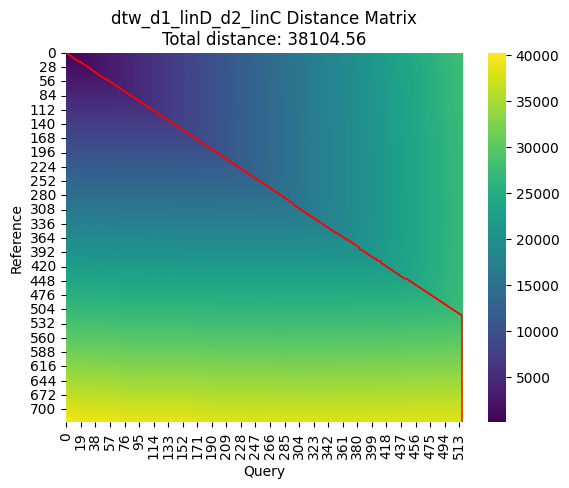

In [10]:
dynchronize(d1_linD, d2_linC, dtw_key="dtw_d1_linD_d2_linC", pseudotime_key="orig_pseudotime")

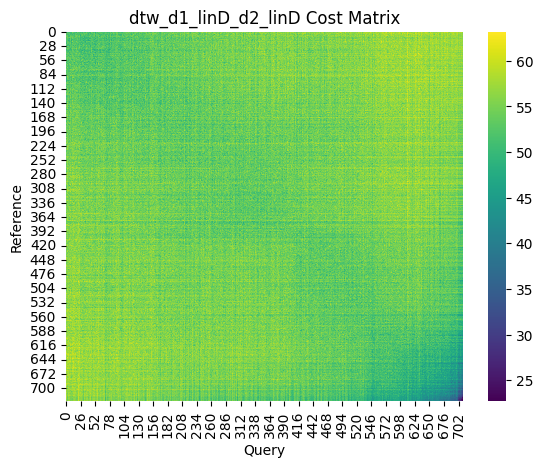

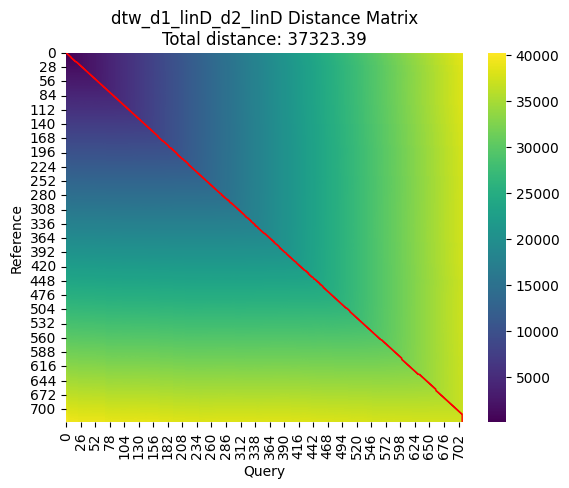

In [11]:
dynchronize(d1_linD, d2_linD, dtw_key="dtw_d1_linD_d2_linD", pseudotime_key="orig_pseudotime")

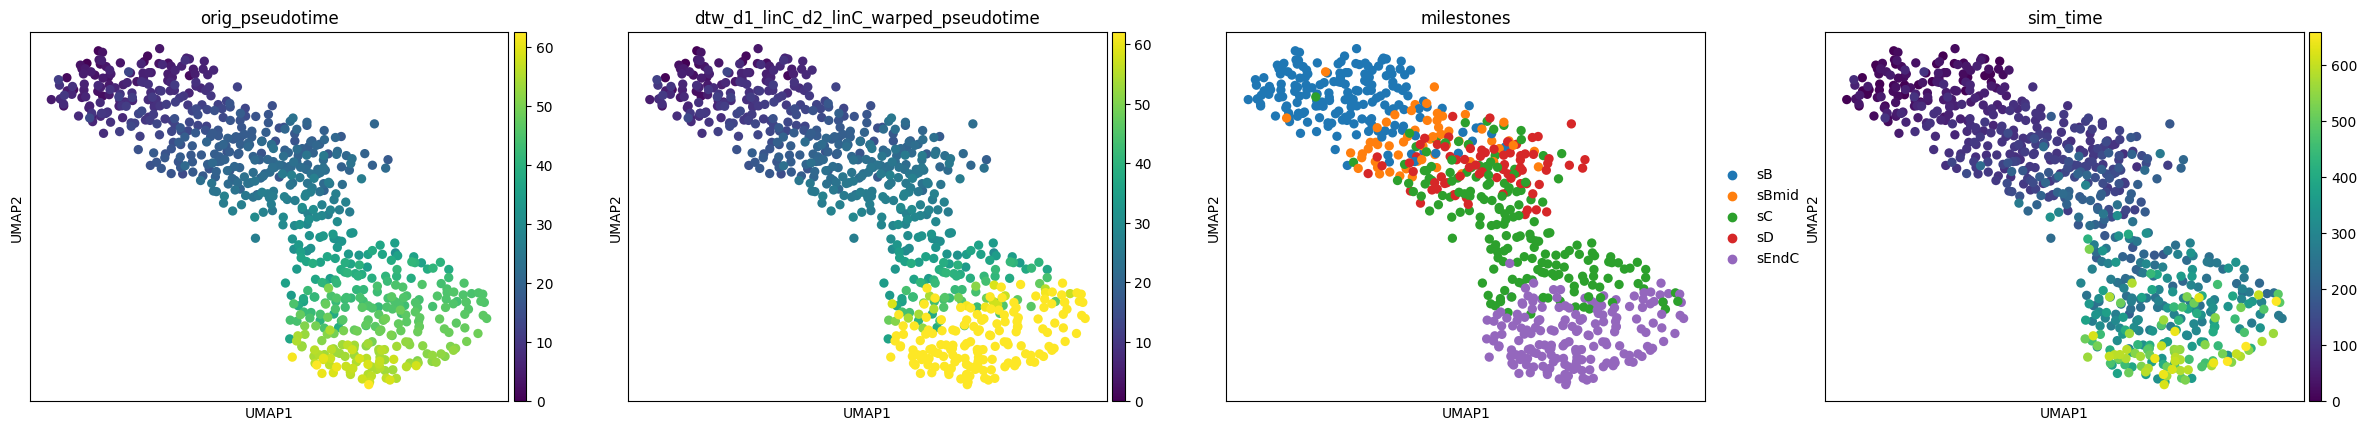

In [12]:
sc.pl.umap(d1_linC, color=["orig_pseudotime", "dtw_d1_linC_d2_linC_warped_pseudotime", "milestones", "sim_time"])

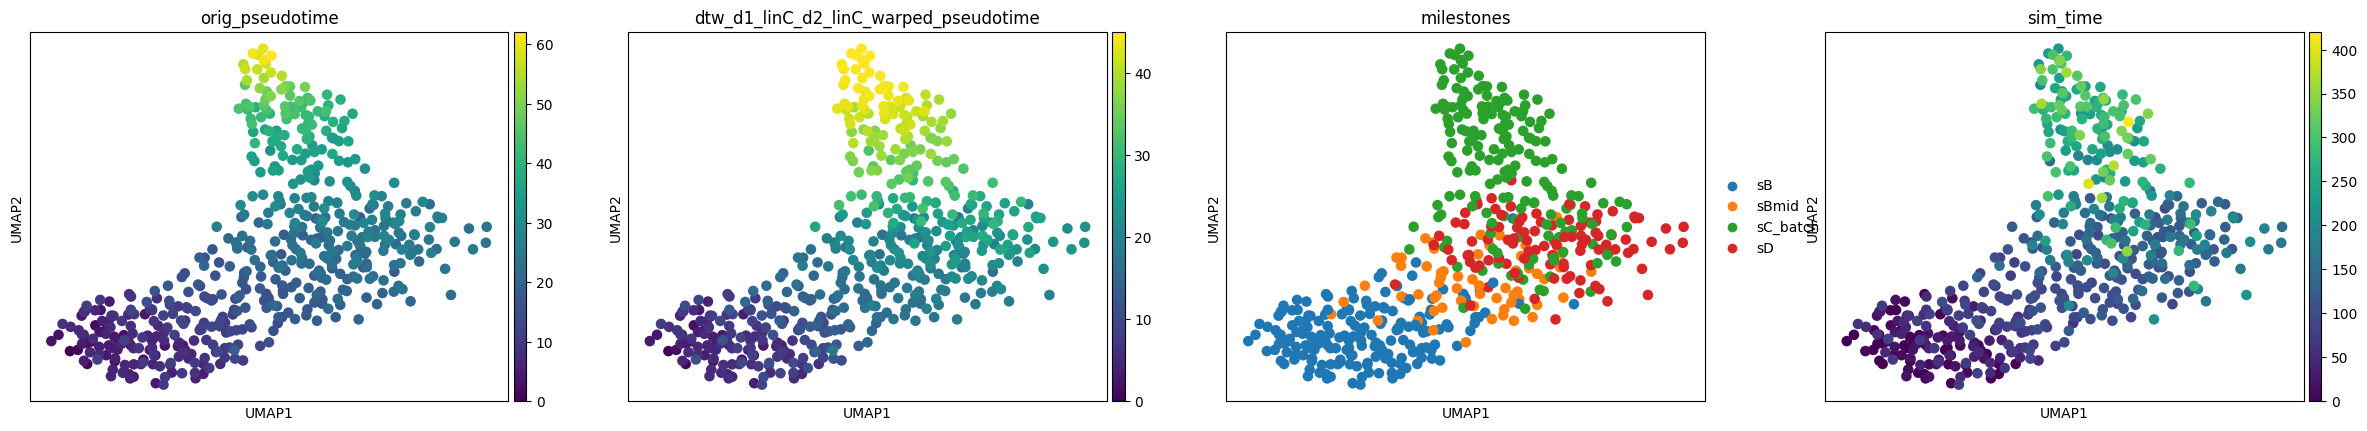

In [13]:
sc.pl.umap(d2_linC, color=["orig_pseudotime", "dtw_d1_linC_d2_linC_warped_pseudotime", "milestones", "sim_time"])

# 4. Compute metrics

In [14]:
linC = ad.concat([d1_linC, d2_linC], axis=0)
linD = ad.concat([d1_linD, d2_linD], axis=0)

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [18]:
# this should be stored in the object too, under uns[dtw_key_kde_x] and uns[dtw_key_kde_y]?
get_kde_eval(linC, "dtw_d1_linC_d2_linC_warped_pseudotime")
get_kde_eval(linC, "orig_pseudotime")

<string>:4: UserWarning: Vector dtw_d1_linC_d2_linC_warped_pseudotime is not normalized between 0 and 1. Normalizing it now and storing as 'norm_dtw_d1_linC_d2_linC_warped_pseudotime'.
<string>:4: UserWarning: Vector orig_pseudotime is not normalized between 0 and 1. Normalizing it now and storing as 'norm_orig_pseudotime'.


AnnData object with n_obs × n_vars = 1186 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'orig_pseudotime', 'dtw_d1_linC_d2_linC_path', 'dtw_d1_linC_d2_linC_cells_path', 'dtw_d1_linC_d2_linC_warped_pseudotime', 'norm_dtw_d1_linC_d2_linC_warped_pseudotime', 'norm_orig_pseudotime'
    uns: 'dtw_d1_linC_d2_linC_warped_pseudotime_kde', 'orig_pseudotime_kde'
    obsm: 'X_pca', 'X_umap', 'dimred', 'dtw_d1_linC_d2_linC_cost', 'dtw_d1_linC_d2_linC_D'
    layers: 'X', 'counts_protein', 'counts_spliced', 'counts_unspliced', 'logcounts'

In [19]:
endc_start = min(d1_linC[d1_linC.obs["milestones"] == "sEndC"].obs["orig_linC_pseudotime"])
min_pt = min(linC.obs["orig_pseudotime"])
max_pt = max(linC.obs["orig_pseudotime"])
endc_start_norm = (endc_start - min_pt) / (max_pt - min_pt)
endc_start_norm

0.5908188837727303

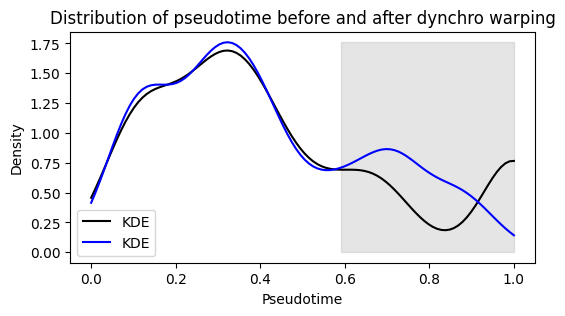

In [20]:
plot_kde_comparison(linC, ["dtw_d1_linC_d2_linC_warped_pseudotime", "orig_pseudotime"], cutoff = endc_start_norm,
                    title = "Distribution of pseudotime before and after dynchro warping")

In [21]:
c_wasserstein = get_wasserstein_distance(linC, pseudotime_keys = ["orig_pseudotime_kde", "dtw_d1_linC_d2_linC_warped_pseudotime_kde"])
print(f"Wasserstein distance before vs after C: {c_wasserstein}")

Wasserstein distance before vs after C: 0.02204178799502315


In [22]:
before, after = get_wasserstein_distance(linC, pseudotime_keys = ["orig_pseudotime_kde", "dtw_d1_linC_d2_linC_warped_pseudotime_kde"], cutoff = endc_start_norm)
print(f"Wasserstein distance before vs after C: {before} vs {after}")

Wasserstein distance before vs after C: 0.0024057447977328204 vs 0.034712762518856244
